In [1]:
import msprime, pyslim
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt


In [29]:
!slim -d 'OUTPATH="pme.trees"' -d WIDTH=20 -d HEIGHT=2 -d NUMGENS=10000 -d DISPERSAL_SIGMA=0.2 -d SIGMA=0.2 pme.slim  >/dev/null

In [30]:
ts = pyslim.load("pme.trees")

In [31]:
print(ts)

╔═══════════════════════════╗
║TreeSequence               ║
╠═══════════════╤═══════════╣
║Trees          │       3934║
╟───────────────┼───────────╢
║Sequence Length│100000000.0║
╟───────────────┼───────────╢
║Sample Nodes   │        682║
╟───────────────┼───────────╢
║Total Size     │    2.8 MiB║
╚═══════════════╧═══════════╝
╔═══════════╤═════╤═════════╤════════════╗
║Table      │Rows │Size     │Has Metadata║
╠═══════════╪═════╪═════════╪════════════╣
║Edges      │42482│  1.1 MiB│          No║
╟───────────┼─────┼─────────┼────────────╢
║Individuals│12167│761.9 KiB│         Yes║
╟───────────┼─────┼─────────┼────────────╢
║Migrations │    0│  4 Bytes│          No║
╟───────────┼─────┼─────────┼────────────╢
║Mutations  │    0│  1.2 KiB│          No║
╟───────────┼─────┼─────────┼────────────╢
║Nodes      │16908│562.1 KiB│         Yes║
╟───────────┼─────┼─────────┼────────────╢
║Populations│    2│  2.8 KiB│         Yes║
╟───────────┼─────┼─────────┼────────────╢
║Provenances│    1│  6.3 

In [32]:
# Trace the path of each currently alive individual backward in time and record the location of the ancestor
# Return (time, x)
inds = ts.individuals_alive_at(0)
# Nodes (genomes) of current individuals
nodes = np.concatenate([ts.individual(i).nodes for i in inds])
# Times of nodes
node_times = ts.tables.nodes.time
# Individual corresponding to each node
node_indivs = ts.tables.nodes.individual
# Locations of individuals
locs = ts.individual_locations
paths = []
tree = ts.first()
for u in nodes:
    uind = node_indivs[u]
    out = [[node_times[u], locs[uind, 0]]]
    u = tree.parent(u)
    while u is not tskit.NULL:
        uind = node_indivs[u]
        out.append([node_times[u], locs[uind, 0]])
        u = tree.parent(u)
    paths.append(np.row_stack(out))
# Each element of paths is the lineage of one current individual

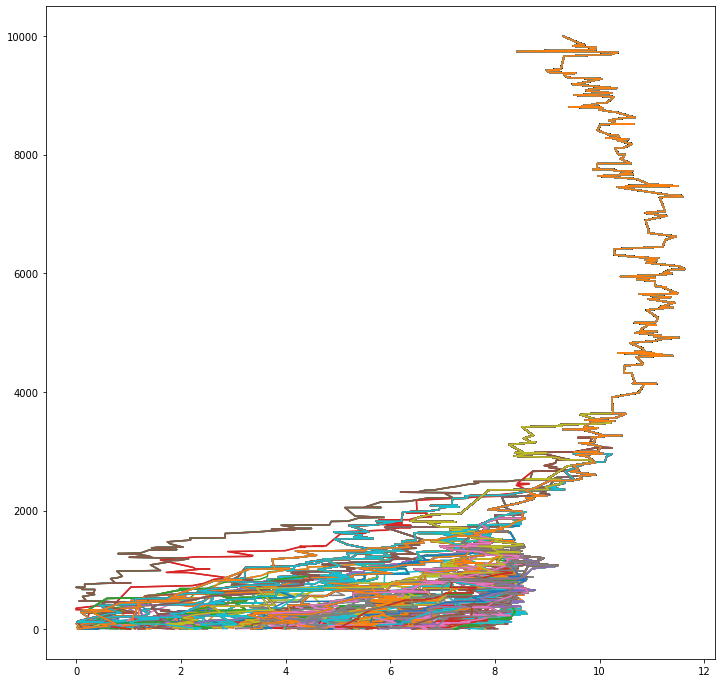

In [36]:
# Plot lineage locations over time
fig, ax = plt.subplots(figsize=(12, 12))
for path in paths:
    ax.plot(path[:,1], path[:,0])